In [1]:
import math
import numpy as np
from IPython.display import clear_output
import pdb
import time

import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable
from torchdiffeq import odeint_adjoint as odeint
from torch.distributions import MultivariateNormal
use_cuda = torch.cuda.is_available()
from geomloss import SamplesLoss


In [2]:
class ODEfunc(nn.Module):
    """
    Calculates time derivatives.

    torchdiffeq requires this to be a torch.nn.Module.
    """

    def __init__(self, hidden_dims=(64,64)):
        super(ODEfunc, self).__init__()
        # Define network layers.
        Z_DIM=2
        dim_list = [Z_DIM] + list(hidden_dims) + [Z_DIM]
        layers = []
        for i in range(len(dim_list)-1):
            layers.append(nn.Linear(dim_list[i]+1, dim_list[i+1]))
        self.layers = nn.ModuleList(layers)


    def get_z_dot(self, t, z):
        # pdb.set_trace()
        """z_dot is parameterized by a NN: z_dot = NN(t, z(t))"""
        z_dot = z
        for l, layer in enumerate(self.layers):
            # Concatenate t at each layer.
            tz_cat = torch.cat((t.expand(z.shape[0],1), z_dot), dim=1)
            z_dot = layer(tz_cat) #add time t into first spot
            #pdb.set_trace()
            if l < len(self.layers) - 1:
                #pdb.set_trace()
                z_dot = F.softplus(z_dot)
        return z_dot

    # d z_dot d z. assuming zdot was computed from z. otherwise output is just 0.
    def getJacobians(self, t, z):
        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):            
            z.requires_grad_(True)
            t.requires_grad_(True)
            z_dot = self.get_z_dot(t, z)
            
            # compute jacobian of velocity field. [N,2,2]
            # inputs z_dot.sum() because each z_dot only depends on one z. no cross derivatives. this batches the grad.
            divergence = 0.0
            dim = z.shape[1];
            jacobians = torch.zeros([batchsize,dim,dim], dtype=z.dtype, device=z.device);
            for i in range(z.shape[1]):
                 jacobians[:,i,:] = torch.autograd.grad( z_dot[:, i].sum(), z, create_graph=True)[0]
        return z_dot, jacobians
    
    def forward(self, t, state):
        """
        Calculate the time derivative of z and divergence.

        Parameters
        ----------
        t : torch.Tensor
            time
        state : torch.Tensor
            Contains z

        Returns
        -------
        z_dot : torch.Tensor
            Time derivative of z.
        negative_divergence : torch.Tensor
            Time derivative of the log determinant of the Jacobian.
        """
        z = state
        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)
            t.requires_grad_(True)

            # Calculate the time derivative of z.
            # This is f(z(t), t; \theta) in Eq. 4.
            z_dot = self.get_z_dot(t, z)

            # compute jacobian of velocity field. [N,2,2]
            # inputs z_dot.sum() because each z_dot only depends on one z. no cross derivatives. this batches the grad.
#             dim = z.shape[1];
#             jacobians = torch.zeros([batchsize,dim,dim], dtype=z.dtype, device=z.device);
#             for i in range(z.shape[1]):
#                  jacobians[:,i,:] = torch.autograd.grad( z_dot[:, i].sum(), z, create_graph=True)[0]
#         return z_dot, jacobians
        return z_dot
        # pdb.set_trace()
        

# In[3]:


class FfjordModel(torch.nn.Module):
    """Continuous noramlizing flow model."""

    def __init__(self):
        super(FfjordModel, self).__init__()
        self.time_deriv_func = ODEfunc()

    def save_state(self, fn='state.tar'):
        """Save model state."""
        torch.save(self.state_dict(), fn)

    def load_state(self, fn='state.tar'):
        """Load model state."""
        self.load_state_dict(torch.load(fn))


    def forward(self, z, integration_times=None, reverse=False):
        """
        Implementation of Eq. 4.
        We want to integrate both f and the trace term. During training, we
        integrate from t_1 (data distribution) to t_0 (base distibution).
        Parameters
        ----------
        z : torch.Tensor
            Samples.
        integration_times : torch.Tensor
            Which times to evaluate at.
        reverse : bool, optional
            Whether to reverse the integration times.
        Returns
        -------
        z : torch.Tensor
            Updated samples.
        """
        if integration_times is None:
            integration_times = torch.tensor([0.0, 1.0]).to(z)
        if reverse:
            integration_times = _flip(integration_times, 0)
        #print('integration_times',integration_times)
        # Integrate. This is the call to torchdiffeq.
        
        state = odeint(
            self.time_deriv_func, # Calculates time derivatives.
            z, # Values to update.
            integration_times, # When to evaluate.
            method='dopri5', # Runge-Kutta
            atol=1e-5, # Error tolerance
            rtol=2e-5, # Error tolerance
        )
        
        z = state
        return z
    
def _flip(x, dim):
    indices = [slice(None)] * x.dim()
    indices[dim] = torch.arange(x.size(dim) - 1, -1, -1, dtype=torch.long,             device=x.device)
    return x[tuple(indices)]



In [3]:


def make_image(n=10000):
    """Make an X shape."""
    points = np.zeros((n,2))
    points[:n//2,0] = np.linspace(-1,1,n//2)
    points[:n//2,1] = np.linspace(1,-1,n//2)
    points[n//2:,0] = np.linspace(1,-1,n//2)
    points[n//2:,1] = np.linspace(1,-1,n//2)
    np.random.seed(42)
    noise = np.clip(np.random.normal(scale=0.1, size=points.shape),-0.2,0.2)
    np.random.seed(None)
    points += noise
    img, _ = np.histogramdd(points, bins=40, range=[[-1.5,1.5],[-1.5,1.5]])
    return img


class ImageDataset():
    """Sample from a distribution defined by an image."""

    def __init__(self, img, MAX_VAL=4.0):
        h, w = img.shape
        xx = np.linspace(-MAX_VAL, MAX_VAL, w)
        yy = np.linspace(-MAX_VAL, MAX_VAL, h)
        xx, yy = np.meshgrid(xx, yy)
        xx = xx.reshape(-1, 1)
        yy = yy.reshape(-1, 1)
        self.means = np.concatenate([xx, yy], 1)
        self.probs = img.reshape(-1) / img.sum()
        self.noise_std = np.array([MAX_VAL/w, MAX_VAL/h])

    def sample(self, batch_size=512):
        inds = np.random.choice(int(self.probs.shape[0]), int(batch_size), p=self.probs)
        m = self.means[inds]
        samples = np.random.randn(*m.shape) * self.noise_std + m
        return torch.from_numpy(samples).type(torch.FloatTensor)



In [4]:


import os
def save_trajectory(model,z_target, my_loss, savedir='imgs', nsteps=20, memory=0.01, n=1000):
    """
    Plot the dynamics of the learned ODE.
    Saves images to `savedir`.
    Parameters
    ----------
    model : FfjordModel
        Model defining the dynamics.
    z_target : torch.Tensor 
        Tensor of shape (T,n,d) where T is the number of timesteps
    myloss : str
        Name of loss used to train the model
    savedir : str, optional
        Where to save output.
    ntimes : int, optional
        Number of timesteps to visualize.
    memory : float
        Controls how finely the density grid is sampled.
    n : int, optional
        Number of samples to visualize.
    """
    
    final_dir = savedir+'/'+my_loss
    if not os.path.exists(final_dir):
        os.makedirs(final_dir)
    
    T = z_target.shape[0]
    x_traj = model(z_target[0,:,:], integration_times= torch.linspace(0,T-1,nsteps).to(device)).cpu().detach()
    x_traj = x_traj.detach().numpy()

    for i in range(nsteps):
        plt.scatter(x_traj[i,:,0], x_traj[i,:,1], s=2.3, alpha=1, linewidths=0.1, c='blue')
        plt.scatter(dat.detach().numpy()[:,0],dat.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='green')
        plt.scatter(dat2.detach().numpy()[:,0],dat2.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='green')
        plt.scatter(dat3.detach().numpy()[:,0],dat3.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='green')

        plt.savefig(os.path.join(final_dir, f"viz-{i:05d}.jpg"))
        plt.clf()



def trajectory_to_video(my_loss,savedir='imgs', mp4_fn='transform.mp4'):
    """Save the images written by `save_trajectory` as an mp4."""
    import subprocess
    final_dir = savedir+'/'+my_loss
    img_fns = os.path.join(final_dir, 'viz-%05d.jpg')
    video_fn = os.path.join(final_dir, mp4_fn)
    bashCommand = 'ffmpeg -y -i {} {}'.format(img_fns, video_fn)
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()



In [7]:


def learn_trajectory(z_target, my_loss, n_batch = 1500):
    
    """
        Learns a trajectory between multiple timesteps contained in z_target
        ----------
        z_target : torch.Tensor 
            Tensor of shape (T,n,d) where T is the number of timesteps
        my_loss : str
            Data fidelity loss, either 'sinkhorn_large_reg', 'sinkhorn_small_reg' or 'energy_distance'
        Returns
        -------
        model : 
            NN representing the vector field
        
        """

    if my_loss == 'sinkhorn_large_reg':
        my_loss_f =SamplesLoss("sinkhorn", p=2, blur=0.01)
    elif my_loss == 'sinkhorn_small_reg':
        my_loss_f = SamplesLoss("sinkhorn", p=2, blur=1)
    else:
        my_loss_f = SamplesLoss("energy") # Energy Distance


    model = FfjordModel()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)

    # get spacetime bounding box and spacetime sample grid
    t_N = 30; x_N = 10; bbscale = 1.1;
    T = z_target.shape[0]; t_sample = torch.linspace(1, T, t_N);
    LL = z_target.min(0)[0].min(0)[0]; TR = z_target.max(0)[0].max(0)[0]; C = (LL+TR)/2; # lower left, top right, center
    eLL = (LL-C)*1.1+C; eTR = (TR-C)*1.1+C; # extended bounding box.
    xspace = torch.linspace(eLL[0],eTR[0],x_N); yspace = torch.linspace(eLL[1],eTR[1],x_N);
    xgrid,ygrid=torch.meshgrid(xspace,yspace);
    z_sample = torch.transpose(torch.reshape(torch.stack([xgrid,ygrid]),(2,-1)),0,1);
    
    losses = []
    start = time.time()
    print('training with %s'%my_loss)
    for batch in range(n_batch):
        if (batch % 10 == 1):
            start = time.time()

        optimizer.zero_grad()
        
        # integrate ODE forward in time
        z_t = model(z_target[0,:,:], integration_times = torch.linspace(0,T-1,T).to(device))
        
        # this is the part where the loss is computed
        fitloss = torch.tensor(0.).to(device)
        for t in range(1,T):
            fitloss += my_loss_f(z_target[t,:,:], z_t[t,:,:])
    
        # add energies depending on velocity field gradient
        div2loss = torch.zeros([t_N,x_N*x_N]).to(device);
        curl2loss = torch.zeros([t_N,x_N*x_N]).to(device);
        for ti in range(t_N):
            t = t_sample[ti]
            z_dots, zt_jacs = model.time_deriv_func.getJacobians(t, z_sample)
            
            div2loss[ti,:] += (zt_jacs[:,0,0]+zt_jacs[:,1,1])**2
            curl2loss[ti,:] += (zt_jacs[:,0,1]-zt_jacs[:,1,0])**2
        
        # combine energies
        loss = fitloss + 0*div2loss.sum() - 2*curl2loss.sum()
        
        losses.append(loss.cpu().detach().numpy())
        loss.backward()
        optimizer.step()
        if (batch % 10 == 0):
            print('batch',batch,'loss',loss)
            
            plt.scatter(z_target.cpu().detach().numpy()[0,:,0], z_target.cpu().detach().numpy()[0,:,1], s=2.3, alpha=.5, linewidths=0.1, c='green', edgecolors='black')
            for t in range(1,T):
                plt.scatter(z_t.cpu().detach().numpy()[t,:,0], z_t.cpu().detach().numpy()[t,:,1], s=2.3, alpha=.5, linewidths=0.1, c='blue', edgecolors='black')
                plt.scatter(z_target.cpu().detach().numpy()[t,:,0], z_target.cpu().detach().numpy()[t,:,1], s=2.3, alpha=.5, linewidths=0.1, c='green', edgecolors='black')
            plt.show()
            print('time elapsed',time.time()-start)

    return model



training with sinkhorn_large_reg
batch 0 loss tensor(278.2753, grad_fn=<SubBackward0>)


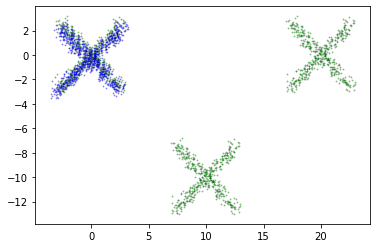

time elapsed 0.35523509979248047
batch 10 loss tensor(-4146.1885, grad_fn=<SubBackward0>)


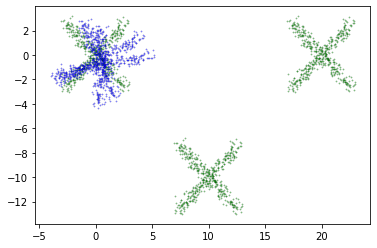

time elapsed 2.3136229515075684
batch 20 loss tensor(-29404.0254, grad_fn=<SubBackward0>)


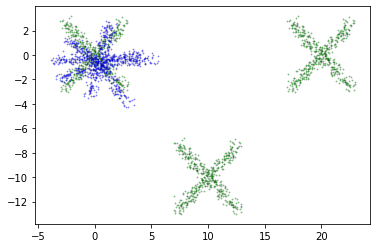

time elapsed 2.4353983402252197
batch 30 loss tensor(-133406.8750, grad_fn=<SubBackward0>)


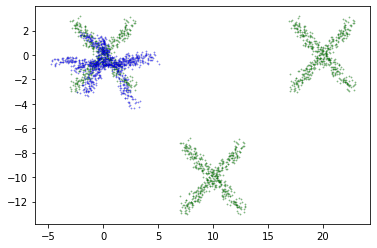

time elapsed 2.686898946762085
batch 40 loss tensor(-489677., grad_fn=<SubBackward0>)


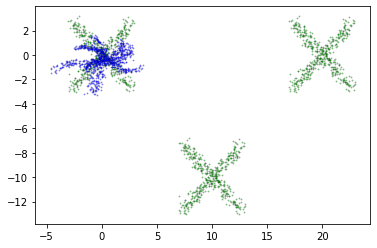

time elapsed 3.497814655303955
batch 50 loss tensor(-1560017., grad_fn=<SubBackward0>)


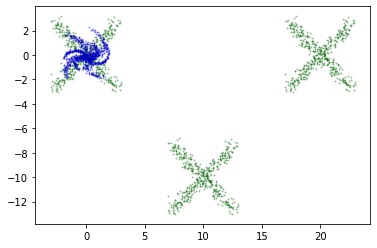

time elapsed 4.60036563873291
batch 60 loss tensor(-4466518.5000, grad_fn=<SubBackward0>)


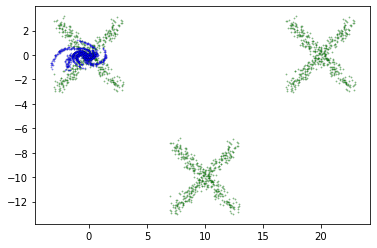

time elapsed 6.255188226699829
batch 70 loss tensor(-11670325., grad_fn=<SubBackward0>)


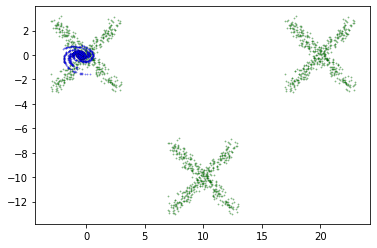

time elapsed 8.63786768913269
batch 80 loss tensor(-28150710., grad_fn=<SubBackward0>)


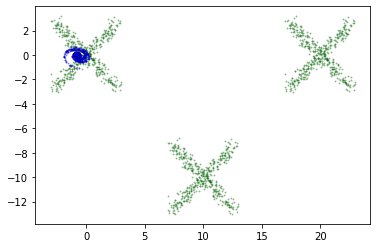

time elapsed 12.822432518005371
batch 90 loss tensor(-63194384., grad_fn=<SubBackward0>)


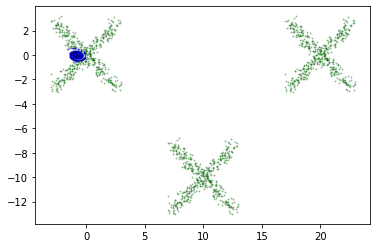

time elapsed 18.790721654891968
batch 100 loss tensor(-1.3304e+08, grad_fn=<SubBackward0>)


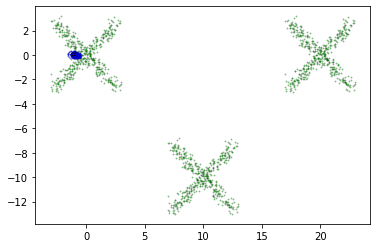

time elapsed 26.133976459503174
batch 110 loss tensor(-2.6458e+08, grad_fn=<SubBackward0>)


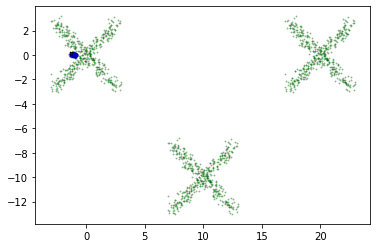

time elapsed 29.452781200408936
batch 120 loss tensor(-5.0028e+08, grad_fn=<SubBackward0>)


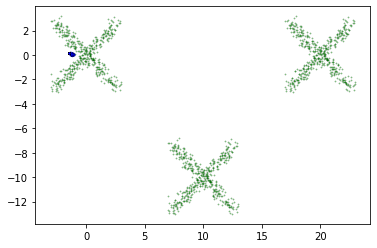

time elapsed 38.670379877090454
batch 130 loss tensor(-9.0491e+08, grad_fn=<SubBackward0>)


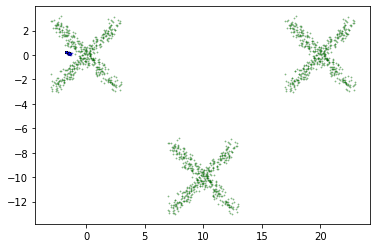

time elapsed 40.09541082382202
batch 140 loss tensor(-1.5743e+09, grad_fn=<SubBackward0>)


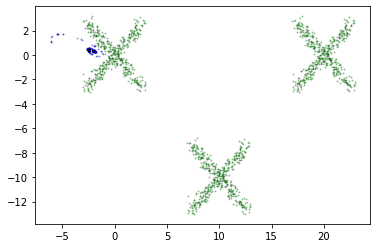

time elapsed 46.45965313911438
batch 150 loss tensor(3.8709e+09, grad_fn=<SubBackward0>)


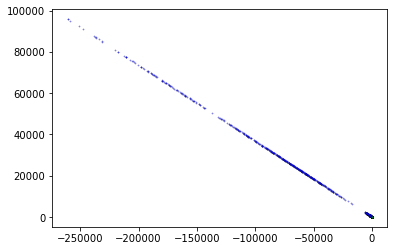

time elapsed 56.526761054992676
batch 160 loss tensor(-2.8493e+09, grad_fn=<SubBackward0>)


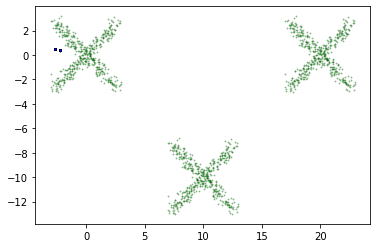

time elapsed 61.424543380737305
batch 170 loss tensor(-3.2147e+09, grad_fn=<SubBackward0>)


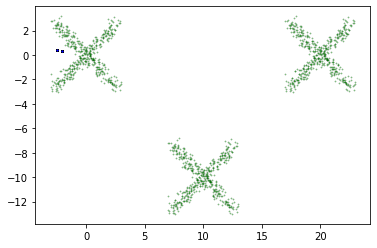

time elapsed 78.09027862548828
batch 180 loss tensor(-3.6932e+09, grad_fn=<SubBackward0>)


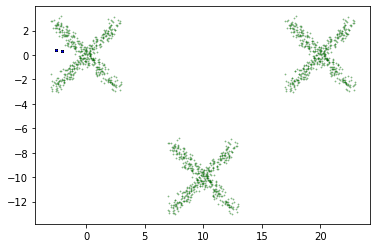

time elapsed 118.06263709068298
batch 190 loss tensor(-4.2764e+09, grad_fn=<SubBackward0>)


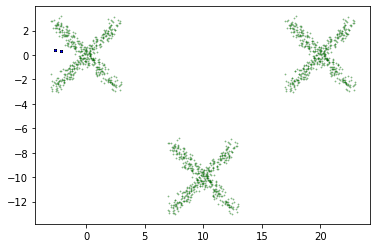

time elapsed 150.5810627937317
batch 200 loss tensor(-4.9791e+09, grad_fn=<SubBackward0>)


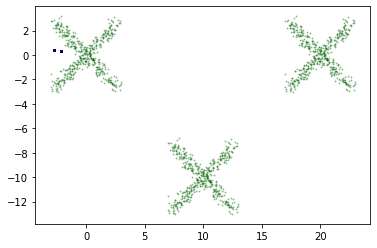

time elapsed 192.86337614059448
batch 210 loss tensor(-5.8337e+09, grad_fn=<SubBackward0>)


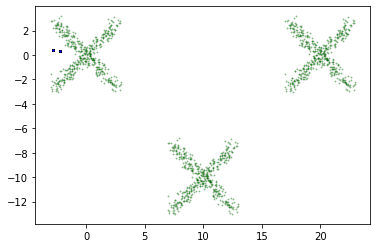

time elapsed 230.8712019920349
batch 220 loss tensor(-6.8830e+09, grad_fn=<SubBackward0>)


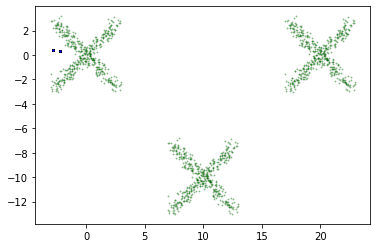

time elapsed 235.70303750038147
batch 230 loss tensor(-8.1867e+09, grad_fn=<SubBackward0>)


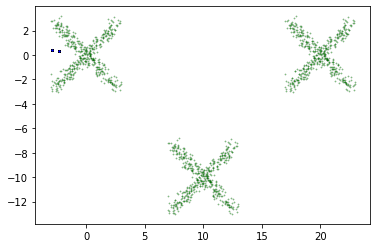

time elapsed 237.8238344192505
batch 240 loss tensor(-9.8220e+09, grad_fn=<SubBackward0>)


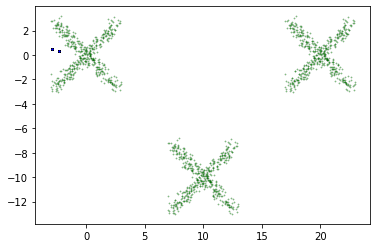

time elapsed 253.8089656829834
batch 250 loss tensor(-1.1892e+10, grad_fn=<SubBackward0>)


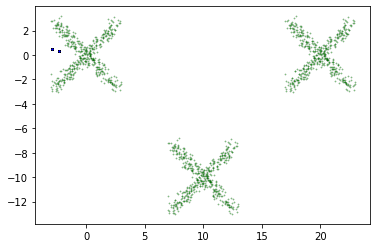

time elapsed 277.9611120223999


In [ ]:
# Example with 3 timesteps
dset = ImageDataset(img=make_image())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dat = dset.sample(512)
dat2 = torch.add(dat,torch.tensor([10,-10]))
dat3 = torch.add(dat,torch.tensor([20,0]))

dat_tuple = (dat,dat2,dat3)
z_target = torch.stack(dat_tuple).to(device)

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=1500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


In [27]:
# Example with 2 timesteps
dset = ImageDataset(img=make_image())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dat = dset.sample(512)
dat2 = torch.add(dat,torch.tensor([10,-10]))

dat_tuple = (dat,dat2)
z_target = torch.stack(dat_tuple).to(device)

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=1000)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


training with sinkhorn_large_reg
> /tmp/ipykernel_3836646/855819122.py(58)learn_trajectory()
     56         # add energies depending on velocity field gradient
     57         pdb.set_trace()
---> 58         divloss = torch.tensor([t_N,x_N*x_N]).to(device);
     59         for t in t_sample:
     60             t_0 = torch.tensor(t, requires_grad=True)



ipdb>  torch.tensor([t_N,x_N*x_N]).to(device)


tensor([ 30, 100])


ipdb>  torch.tensor([t_N,x_N*x_N]).to(device).dtype


torch.int64


ipdb>  torch.tensor([t_N,x_N*x_N]).to(device)+.1


tensor([ 30.1000, 100.1000])
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


/tmp/ipykernel_3836646/855819122.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  divloss = torch.tensor([t_N,x_N*x_N]).to(device);


RuntimeError: result type Float can't be cast to the desired output type Long